# Tracking options

We explore the impact of some of the tracking options for two of the sample datasets.

```{important}
This notebook was run with TAMS v0.1 and has not been updated for changes in v0.2.
Some tweaks may be necessary to run it with the latest version.
```

In [1]:
import warnings
from string import ascii_lowercase

import cartopy.io
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from IPython.display import display, Markdown
from joblib import delayed, Parallel
from scipy.stats import gaussian_kde

import tams

warnings.filterwarnings("ignore", category=cartopy.io.DownloadWarning)

plt.rcParams.update(
    {
        "axes.formatter.use_mathtext": True,
    }
)

%matplotlib inline

xr.set_options(display_expand_data=False)

## For sample satellite data

In [2]:
tb = tams.load_example_tb()
tb

<xarray.DataArray 'ch9' (time: 6, y: 714, x: 2829)>
295.9 295.9 295.8 295.8 295.8 295.9 295.9 295.8 ... nan nan nan nan nan nan nan
Coordinates:
    lon      (time, y, x) float32 ...
    lat      (time, y, x) float32 ...
  * time     (time) datetime64[ns] 2006-09-01 ... 2006-09-01T10:00:00
Dimensions without coordinates: y, x
Attributes:
    units:      K
    long_name:  Brightness temperature

### Identify cloud elements (CEs)

Our tracking options cases here are all in the tracking stage, so we only have to run {func}`tams.identify` once.

In [3]:
%%time

ces, _ = tams.identify(tb, parallel=True)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.


CPU times: total: 156 ms
Wall time: 5.23 s


[Parallel(n_jobs=-2)]: Done   2 out of   6 | elapsed:    5.0s remaining:   10.0s
[Parallel(n_jobs=-2)]: Done   3 out of   6 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-2)]: Done   4 out of   6 | elapsed:    5.0s remaining:    2.4s
[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:    5.0s finished


### Run cases

In [4]:
%%time

cases = {}
time = tb.time.values.tolist()

proj = -15

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="forward `look` considered experimental")
    cases["default"] = tams.track(ces, time)
    cases["link=f, norm=min"] = tams.track(ces, time, look="f", overlap_norm="min")
    cases["link=f, norm=max"] = tams.track(ces, time, look="f", overlap_norm="max")
    cases[f"u_proj={proj}"] = tams.track(ces, time, u_projection=proj)
    cases[f"u_proj={proj}, link=f, norm=min"] = tams.track(ces, time, u_projection=proj, look="f", overlap_norm="min")
    cases[f"u_proj={proj}, link=f, norm=max"] = tams.track(ces, time, u_projection=proj, look="f", overlap_norm="max")

for key, ce in cases.items():
    cases[key] = tams.classify(ce)

CPU times: total: 5.05 s
Wall time: 5.15 s


### Plot CEs

And check if the method produced a single track within the box, saving a table of these results.

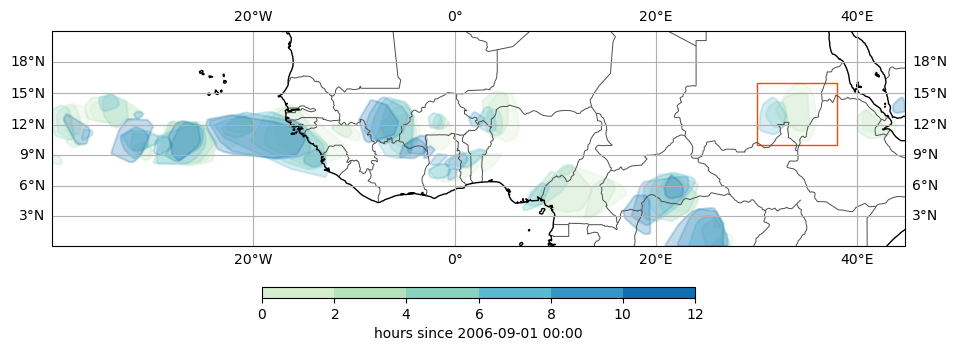

In [5]:
m, n = 2, 3
assert len(cases) <= m * n

# Restrict range
# lon_min, lat_min, lon_max, lat_max = -10, 8, -3, 15
# lon_min, lat_min, lon_max, lat_max = 17, 1, 27, 8
# lon_min, lat_min, lon_max, lat_max = 20, 1, 27, 4
lon_min, lat_min, lon_max, lat_max = 30, 10, 38, 16

cases_full = []
for key in cases:
    d = {"u_proj": 0, "link": "b", "norm": "a"}
    updates = {}
    if key != "default":
        for kv in key.split(", "):
            k, v = kv.split("=")
            updates[k] = v
        if "norm" not in updates and updates.get("link", "b").startswith("f"):
            d["norm"] = "b"
    d.update(updates)
    cases_full.append(d)
tbl = pd.DataFrame(cases_full)
tbl = tbl.assign(continued=False)

for i, (_, ce) in enumerate(cases.items()):
    n = ce.cx[lon_min:lon_max, lat_min:lat_max].mcs_id.nunique()
    assert n in {1, 2}
    if n == 1:
        tbl.loc[i, "continued"] = True

tams.plot_tracked(ce, label="none", size=3.5, add_colorbar=True, cbar_kwargs=dict(fraction=0.05, shrink=0.3))

ax = plt.gca()
patch = mpl.patches.Polygon(
    [(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max), (lon_max, lat_min)],
    ec="orangered",
    fill=False,
    transform=ccrs.PlateCarree(),
)
ax.add_patch(patch)

# proj = ccrs.PlateCarree()

# fig, axs = plt.subplots(m, n, figsize=(8, 5), sharex=True, sharey=True, subplot_kw=dict(projection=proj), constrained_layout=True)

# for i, ((key, ce), ax) in enumerate(zip(cases.items(), axs.flat)):
#     if i == 0:
#         assert key == "default"
#         tams.plot_tracked(ce)
    
#     tams.plot_tracked(ce.cx[lon_min:lon_max, lat_min:lat_max], ax=ax)
#     ax.text(0.03, 0.98, key, ha="left", va="top", transform=ax.transAxes, size=8)
#     gl = ax.gridlines(draw_labels=True, color="none")
#     if not i < n:
#         gl.top_labels = False
#     if not i % n == 0:
#         gl.left_labels = False

with open("sat-tracking-options-table.txt", "w") as f:
    f.write(tbl.assign(continued=tbl.continued.map({True: "y", False: "n"})).style.to_latex())

plt.savefig("sat-tracking-options-ces-box.pdf", bbox_inches="tight", pad_inches=0.05, transparent=False)

## For sample MPAS lat/lon dataset

In [6]:
ds = tams.load_example_mpas().isel(time=slice(1, None)).rename_vars(tb="ctt", precip="pr")
ds

<xarray.Dataset>
Dimensions:  (time: 126, lon: 341, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 2006-09-08T13:00:00 ... 2006-09-13T18:00:00
  * lon      (lon) float64 85.0 85.25 85.5 85.75 ... 169.2 169.5 169.8 170.0
  * lat      (lat) float64 -4.875 -4.625 -4.375 -4.125 ... 39.38 39.62 39.88
Data variables:
    ctt      (time, lat, lon) float32 266.8 266.9 267.0 ... 266.0 265.9 265.7
    pr       (time, lat, lon) float32 ...

(ctt_thresh_data_in_contours)=
### Identify CEs using different CTT thresholds

For CEs (not necessarily for MCSs), the CTT threshold only affects identification.

Here we use {func}`tams.data_in_contours` to add a few cloud-top temperature
and precipitation rate statistics to our CE dataset.

In [7]:
%%time

ctt = ds.ctt
precip = ds.pr

thresh = 235
thresh_core = 219

cases_ces = {}
for delta in [-15, 0, 5]:
    if delta == 0:
        key = rf"default ($T = {thresh}\,\mathrm{{K}}$, $T_\mathrm{{core}} = {thresh_core}\,\mathrm{{K}}$)"
    else:
        s_delta = str(delta) if delta <= 0 else f"+{delta}"
        key = rf"$(T, T_\mathrm{{core}}) {s_delta}$"
    ces = tams.identify(ctt,
        parallel=True,
        ctt_threshold=thresh + delta,
        ctt_core_threshold=thresh_core + delta,
    )[0]

    assert len(ces) == ds.sizes["time"]
    
    # Add min Tb and avg precip -- parallel
    def fun(ds, ce):
        ce = tams.data_in_contours(ds.ctt, ce, agg=("mean", "min",), merge=True)
        ce = tams.data_in_contours(ds.pr, ce, agg=("mean",), merge=True)
        return ce
    
    ces_ = Parallel(n_jobs=-2, verbose=10)(
        delayed(fun)(ds.isel(time=i).copy(deep=False), ce.copy())
        for i, ce in enumerate(ces)
    )
    cases_ces[key] = ces_

    # # Add min Tb and avg precip -- serial
    # for i, ce in enumerate(ces):
    #     ce = tams.data_in_contours(ctt.isel(time=i), ce, agg=("min",), merge=True)
    #     ce = tams.data_in_contours(precip.isel(time=i), ce, agg=("mean",), merge=True)
    #     ces[i] = ce
    #     print(".", end="")
    # print()
    # cases_ces[key] = ces

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-2)]: Done  39 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done  63 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-2)]: Done  76 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-2)]: Done  91 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-2)]: Done 118 out of 126 | elapsed:   11.8s remaining:    0.7s
[Parallel(n_jobs=-2)]: Done 126 out of 126 | elapsed:   12.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_

CPU times: total: 9.81 s
Wall time: 2min 5s


[Parallel(n_jobs=-2)]: Done 126 out of 126 | elapsed:   26.8s finished


### Track for different $u$ projection values

For each of our CTT threshold cases,
we track using different $u$ projection values,
bringing the case count to 9.

In [8]:
%%time

cases = {}
time = ctt.time.values.tolist()

projs = [-5, -10, -12]
for proj in projs:
    for thresh_key, ces in cases_ces.items():
        key = rf"{thresh_key}, $u_\mathrm{{proj}} = {proj}\,\mathrm{{m}}\,\mathrm{{s}}^{{-1}}$"
        cases[key] = tams.track(ces, time, u_projection=proj)

CPU times: total: 1min 44s
Wall time: 1min 45s


### Check the case labels

1. `$(T, T_\mathrm{core}) -15$, $u_\mathrm{proj} = -5\,\mathrm{m}\,\mathrm{s}^{-1}$`

2. `default ($T = 235\,\mathrm{K}$, $T_\mathrm{core} = 219\,\mathrm{K}$), $u_\mathrm{proj} = -5\,\mathrm{m}\,\mathrm{s}^{-1}$`

3. `$(T, T_\mathrm{core}) +5$, $u_\mathrm{proj} = -5\,\mathrm{m}\,\mathrm{s}^{-1}$`

4. `$(T, T_\mathrm{core}) -15$, $u_\mathrm{proj} = -10\,\mathrm{m}\,\mathrm{s}^{-1}$`

5. `default ($T = 235\,\mathrm{K}$, $T_\mathrm{core} = 219\,\mathrm{K}$), $u_\mathrm{proj} = -10\,\mathrm{m}\,\mathrm{s}^{-1}$`

6. `$(T, T_\mathrm{core}) +5$, $u_\mathrm{proj} = -10\,\mathrm{m}\,\mathrm{s}^{-1}$`

7. `$(T, T_\mathrm{core}) -15$, $u_\mathrm{proj} = -12\,\mathrm{m}\,\mathrm{s}^{-1}$`

8. `default ($T = 235\,\mathrm{K}$, $T_\mathrm{core} = 219\,\mathrm{K}$), $u_\mathrm{proj} = -12\,\mathrm{m}\,\mathrm{s}^{-1}$`

9. `$(T, T_\mathrm{core}) +5$, $u_\mathrm{proj} = -12\,\mathrm{m}\,\mathrm{s}^{-1}$`

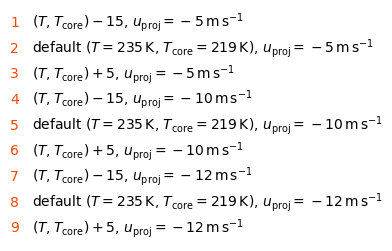

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.axis("off")

lines = []
for i, k in enumerate(cases):
    lines.append(f"{i+1}. `{k}`")
    y = len(cases) - i - 0.5
    ax.text(0, y, i + 1, va="center", ha="left", color="orangered")
    ax.text(0.07, y, k, va="center", ha="left")

ax.set_ylim(ymax=len(cases))

display(Markdown("\n\n".join(lines)))

### Plot area dist

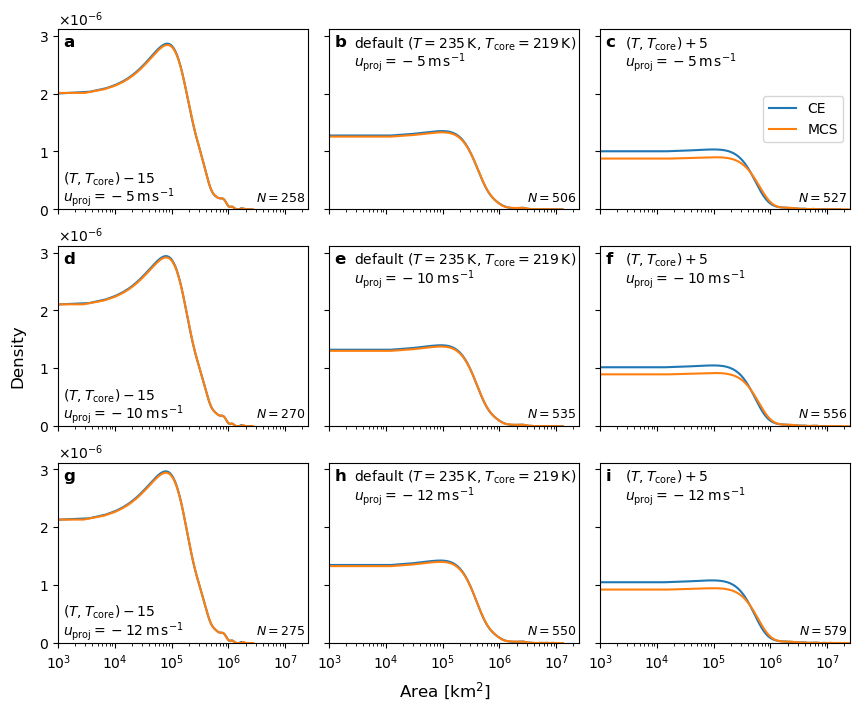

In [10]:
m = len(projs)
n = 3
assert m * n == len(cases)

fig, axs = plt.subplots(m, n, figsize=(8.2, 7), sharex=True, sharey=True, constrained_layout=True)

for a, (key, ce), ax in zip(ascii_lowercase, cases.items(), axs.flat):
    n = ce.mcs_id.nunique()
    # Dist of max area
    x = ce.groupby("mcs_id").area_km2.max()
    x.plot.kde(ax=ax, label="CE")
    
    mcs = ce.groupby(["mcs_id", "itime"]).area_km2.sum()
    x2 = mcs.groupby("mcs_id").max()
    x2.plot.kde(ax=ax, label="MCS")
    
    ax.text(0.99, 0.03, f"$N={n}$", size=9, ha="right", va="bottom", transform=ax.transAxes)
    
    i = key.index(", $u_")
    l1, l2 = key[:i], key[i+2:]
    if ax.get_subplotspec().is_first_col():
        xt, yt = 0.02, 0.22
    else:
        xt, yt = 0.1, 0.97
    ax.text(xt, yt, l1, size=10, ha="left", va="top", transform=ax.transAxes)
    ax.text(xt, yt - 0.09, l2, size=10, ha="left", va="top", transform=ax.transAxes)
    
    ax.set_ylabel("")
    ax.text(0.02, 0.97, f"{a}",
        size=12, weight="bold",
        ha="left", va="top",
        transform=ax.transAxes,
    )
    if a == "c":
        ax.legend(loc="center right")

fig.supxlabel("Area [km$^2$]")
fig.supylabel("Density", x=-0.03)

# ax.set_xlim(xmin=0)
ax.set_xlim(xmin=1000); ax.set_xscale("log")
ax.set_ylim(ymin=0)

fig.savefig("mpas-tracking-options-area-kde.pdf", bbox_inches="tight", pad_inches=0.05, transparent=False)

### Plot 2-D duration and area dist

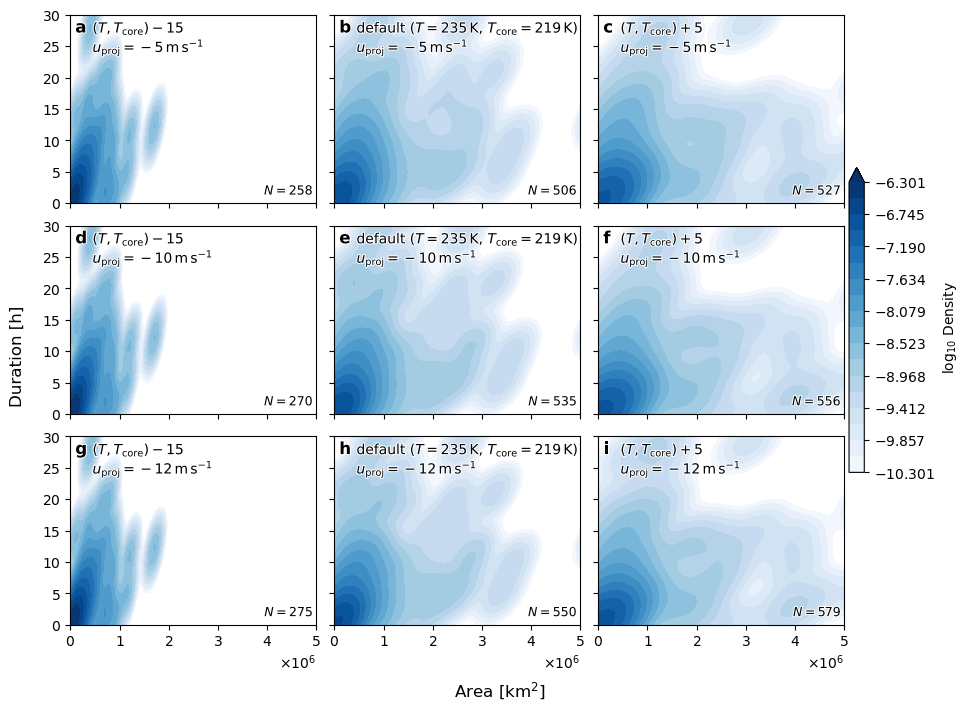

In [11]:
m = len(projs)
n = 3
assert m * n == len(cases)

fig, axs = plt.subplots(m, n, figsize=(9.25, 7), sharex=True, sharey=True, constrained_layout=True)

for a, (key, ce), ax in zip(ascii_lowercase, cases.items(), axs.flat):
    n = ce.mcs_id.nunique()
    gb = ce.groupby("mcs_id")
    area = gb.area_km2.max()
    dur = ((gb.time.max() - gb.time.min()).dt.total_seconds() / 3600).rename("duration_h")
    data = pd.concat([area, dur], axis="columns")

    # Manual KDE, so we can share a colorbar
    kde = gaussian_kde(np.column_stack((data["area_km2"], data["duration_h"])).T)
    X, Y = np.mgrid[0:5e6:100j, 0:30:100j]
    pos = np.column_stack((X.ravel(), Y.ravel())).T
    Z = np.reshape(kde(pos).T, X.shape)
    im = ax.contourf(
        X, Y, np.log10(np.where(Z > 0, Z, np.nan)),
        levels=np.linspace(np.log10(5e-11), np.log10(5e-7), 19),
        extend="max",
        cmap=sns.color_palette("Blues", as_cmap=True),
    )

    ax.text(0.99, 0.03, f"$N={n}$",
        size=9,
        ha="right", va="bottom",
        path_effects=[path_effects.withStroke(linewidth=1.5, foreground="w")],
        transform=ax.transAxes,
    )
   
    i = key.index(", $u_")
    l1, l2 = key[:i], key[i+2:]
    xt, yt = 0.09, 0.975
    kws = dict(
        size=10,
        ha="left", va="top",
        path_effects=[path_effects.withStroke(linewidth=1.5, foreground="w")],
        transform=ax.transAxes,
    )
    ax.text(xt, yt, l1, **kws)
    ax.text(xt, yt - 0.09, l2, **kws)
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(0.02, 0.97, f"{a}",
        size=12, weight="bold",
        ha="left", va="top",
        path_effects=[path_effects.withStroke(linewidth=1.5, foreground="w")],
        transform=ax.transAxes,
    )

cbar = fig.colorbar(im, ax=axs, shrink=0.5, pad=0,
    label="log$_{10}$ Density",
    extend="max",
)

fig.supxlabel("Area [km$^2$]")
fig.supylabel("Duration [h]", x=-0.03)

ax.set_xlim(xmin=0, xmax=0.5e7)
ax.set_ylim(ymin=0, ymax=30)

fig.savefig("mpas-tracking-options-duration-area-2d-kde.pdf", bbox_inches="tight", pad_inches=0.05, transparent=False)

In [12]:
list(cases.values())[0].head(3)

,geometry,area_km2,inds219,area219_km2,cs219,mean_ctt,min_ctt,mean_pr,time,itime,dtime,mcs_id
0,"POLYGON ((152.50000 8.93176, 154.09671 11.1250...",65189.730096,"[1, 2, 3, 4]",7632.145729,"MULTIPOLYGON (((154.00000 11.33169, 154.00332 ...",223.781916,199.467636,2.174953,2006-09-08 13:00:00,0,0 days 01:00:00,0
1,"POLYGON ((105.00000 20.86816, 105.04808 20.875...",43468.589233,[8],11043.783834,"MULTIPOLYGON (((105.00000 21.04446, 105.25000 ...",217.004782,196.3992,3.237674,2006-09-08 13:00:00,0,0 days 01:00:00,1
2,"POLYGON ((103.75000 0.07912, 103.83888 0.12500...",98642.412303,"[9, 10, 11]",38699.492801,"MULTIPOLYGON (((103.25000 1.66696, 103.28213 1...",216.819586,195.909149,3.098599,2006-09-08 13:00:00,0,0 days 01:00:00,2


### Plot 2-D CTT and precip dist

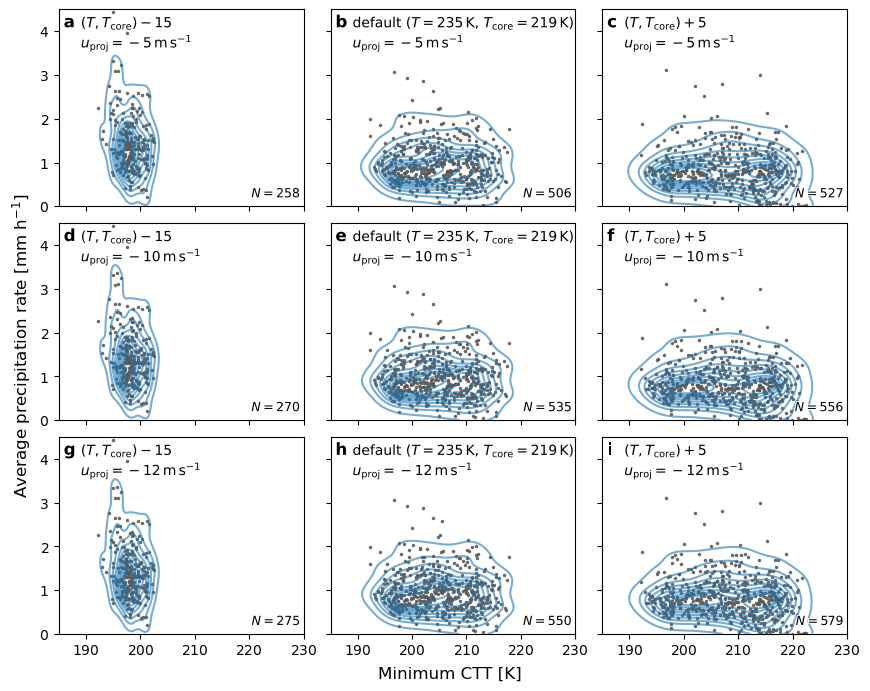

In [13]:
m = len(projs)
n = 3
assert m * n == len(cases)

fig, axs = plt.subplots(m, n, figsize=(8.3, 6.8), sharex=True, sharey=True, constrained_layout=True)

for a, (key, ce), ax in zip(ascii_lowercase, cases.items(), axs.flat):    
    n = ce.mcs_id.nunique()
    gb = ce.groupby("mcs_id")
    tb = gb.min_ctt.min().astype(float)  # np.sqrt not supported for `Float64`
    pr = gb.mean_pr.mean().astype(float)  # TODO: area-weighted average of CE precip at each time?
    data = pd.concat([tb, pr], axis="columns")

    ax.plot(tb, pr, ".", ms=5, mec="none", mfc="0.35", alpha=0.9)
    
    sns.kdeplot(x="min_ctt", y="mean_pr",
        fill=False, color=sns.color_palette()[0], alpha=0.6,
        common_norm=True, clip=(0, None),
        ax=ax, data=data,
    )
    
    ax.text(0.99, 0.03, f"$N={n}$",
        size=9,
        ha="right", va="bottom",
        path_effects=[path_effects.withStroke(linewidth=1.5, foreground="w")],
        transform=ax.transAxes,
    )
   
    i = key.index(", $u_")
    l1, l2 = key[:i], key[i+2:]
    xt, yt = 0.09, 0.975
    kws = dict(
        size=10,
        ha="left", va="top",
        path_effects=[path_effects.withStroke(linewidth=1.5, foreground="w")],
        transform=ax.transAxes,
    )
    ax.text(xt, yt, l1, **kws)
    ax.text(xt, yt - 0.09, l2, **kws)
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(0.02, 0.97, f"{a}",
        size=12, weight="bold",
        ha="left", va="top",
        path_effects=[path_effects.withStroke(linewidth=1.5, foreground="w")],
        transform=ax.transAxes,
    )

fig.supxlabel("Minimum CTT [K]")
fig.supylabel("Average precipitation rate [mm h$^{-1}$]", x=-0.03)

ax.set_xlim(xmin=185, xmax=230)
ax.set_ylim(ymin=0, ymax=4.5)

fig.savefig("mpas-tracking-options-tb-pr-2d-kde.pdf", bbox_inches="tight", pad_inches=0.05, transparent=False)

## Versions

In [14]:
%load_ext watermark

In [15]:
%watermark -uiz -v -m -g -w -p cartopy,dask,gdown,geopandas,joblib,matplotlib,netCDF4,numpy,pandas,pygeos,regionmask,scipy,seaborn,shapely,skimage,xarray

Last updated: 2024-06-20T12:34:52.737871-06:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.18.1

cartopy   : 0.22.0
dask      : 2024.1.1
gdown     : 5.1.0
geopandas : 0.14.3
joblib    : 1.3.2
matplotlib: 3.8.1
netCDF4   : 1.6.4
numpy     : 1.26.3
pandas    : 1.5.3
pygeos    : 0.14
regionmask: 0.12.1
scipy     : 1.12.0
seaborn   : 0.11.0
shapely   : 2.0.1
skimage   : 0.22.0
xarray    : 2024.1.1

Compiler    : MSC v.1937 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit

Git hash: 05d7d8c76139d4f90dcdfbacfc92c434d50675e5

Watermark: 2.4.3

